In [1]:
import pandas as pd
import matplotlib as mp

%matplotlib inline

In [2]:
auctions = pd.read_csv('../data/auctions.csv.gzip',compression='gzip',\
                        usecols=['date','device_id','platform','ref_type_id','source_id'],\
                        dtype={'device_id':'int64','platform':'category','ref_type_id':'category','source_id':'category'},\
                        parse_dates=['date'])

## Cada 3 dias, cuantas veces aparece un mismo id en promedio?

In [3]:
auctions.head()

,date,device_id,platform,ref_type_id,source_id
0,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


Primero se busca cuanto es el promedio de veces que aparece un usuario en las subastas. 

Se usan grupos de 3 dias para segmentar los datos ya que es la ventana que toma Jaamp.


In [4]:
#Divido el intervalo en segmentos de 3 dias consecutivos que analizo por separado
auctions['date_frame'] = (auctions['date'].dt.day - auctions['date'].dt.day.min()) % 3
grp = ['device_id', 'date_frame']

Wall time: 0 ns
Prom. de apariciones de usuarios en 3 dias:  43.157112615493176
Min. de apariciones de usuarios en 3 dias:  1
Max. de apariciones de usuarios en 3 dias:  11910
Med. de apariciones de usuarios en 3 dias:  9.0
Total de Registros:  453490


Text(0,0.5,'Cant. Usuarios')

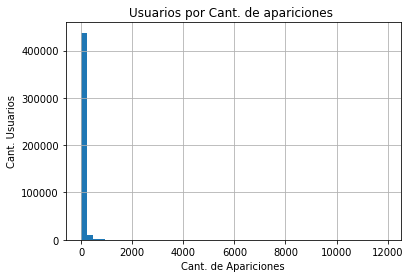

In [5]:
%time
app_dev_id = auctions.groupby(grp)['date'].count()
print('Prom. de apariciones de usuarios en 3 dias: ', app_dev_id.mean())
print('Min. de apariciones de usuarios en 3 dias: ', app_dev_id.min())
print('Max. de apariciones de usuarios en 3 dias: ', app_dev_id.max())
print('Med. de apariciones de usuarios en 3 dias: ', app_dev_id.median())
print('Total de Registros: ', app_dev_id.count())

plot = app_dev_id.hist(bins=50)
plot.set_title("Usuarios por Cant. de apariciones ")
plot.set_xlabel("Cant. de Apariciones")
plot.set_ylabel("Cant. Usuarios")

Elimino los que aparecen una sola vez (no se puede estimar tiempo de arribo) y los que aparecen mas de 1000 veces (No tiene sentido, estan muy por arriba de la mediana)

Prom. de apariciones de usuarios en 3 dias:  27.35093602995296
Min. de apariciones de usuarios en 3 dias:  3
Max. de apariciones de usuarios en 3 dias:  149
Med. de apariciones de usuarios en 3 dias:  14.0
Total de Registros:  312490


Text(0,0.5,'Cant. Usuarios')

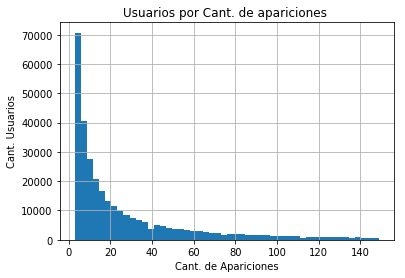

In [6]:
min_value = 2
max_value = 150

#Entre 1 y 1000 quedan 381582 registros 
#Entre 1 y 300 quedan 371666 registros
#Entre 5 y 200 quedan 250549 registros

app_dev_id_filtered = auctions.groupby(grp).filter(lambda data: ((len(data) > min_value) & (len(data) < max_value)))
                                                                                                                  
app_dev_id = app_dev_id_filtered.groupby(grp)['date'].count()
print('Prom. de apariciones de usuarios en 3 dias: ', app_dev_id.mean())
print('Min. de apariciones de usuarios en 3 dias: ', app_dev_id.min())
print('Max. de apariciones de usuarios en 3 dias: ', app_dev_id.max())
print('Med. de apariciones de usuarios en 3 dias: ', app_dev_id.median())
print('Total de Registros: ', app_dev_id.count())

plot = app_dev_id.hist(bins=50)
plot.set_title("Usuarios por Cant. de apariciones ")
plot.set_xlabel("Cant. de Apariciones")
plot.set_ylabel("Cant. Usuarios")

## Cada 3 dias, cuanto es el tiempo promedio entre apariciones de un dispositivo? 

In [7]:
#con app_dev_id calcular el tiempo entre una apricion y otra aparicion y promediarlo por usuario y luego por total.
app_dev_id_filtered.head()

,date,device_id,platform,ref_type_id,source_id,date_frame
3,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0,0
7,2019-03-11 14:18:42.823963,160071254383181872,1,1,0,0
9,2019-03-11 14:18:44.470248,2960551690927930513,1,1,0,0
10,2019-03-11 14:18:47.603990,6306824739731026067,1,1,0,0
11,2019-03-11 14:18:48.424327,3936313574333788462,1,1,0,0


In [8]:
%time
grouped_ordered = app_dev_id_filtered.groupby(grp, as_index = False)\
                                     .apply(lambda x: x.sort_values(by='date'))
grouped_ordered.head()

Wall time: 0 ns


date        device_id platform ref_type_id  \
0 16055271 2019-03-08 11:20:19.361762  113858820194433        1           1   
  7910618  2019-03-08 11:20:19.411501  113858820194433        1           1   
  10114916 2019-03-08 13:41:53.701108  113858820194433        1           1   
  10198607 2019-03-11 00:47:34.259903  113858820194433        1           1   
  17311907 2019-03-11 22:05:35.290441  113858820194433        1           1   

           source_id  date_frame  
0 16055271         0           0  
  7910618          0           0  
  10114916         0           0  
  10198607         0           0  
  17311907         0           0

In [12]:
grouped_ordered['next_date'] = grouped_ordered.groupby(grp, as_index = False)['date'].transform(lambda x: x.shift(-1))
grouped_ordered = grouped_ordered.loc[(~grouped_ordered['next_date'].isnull())]
grouped_ordered['secs_to_next'] = (grouped_ordered['next_date'] - grouped_ordered['date']).transform(lambda x: round(x.total_seconds(), 2))

In [16]:
grouped_ordered.head()

date        device_id platform ref_type_id  \
0 16055271 2019-03-08 11:20:19.361762  113858820194433        1           1   
  7910618  2019-03-08 11:20:19.411501  113858820194433        1           1   
  10114916 2019-03-08 13:41:53.701108  113858820194433        1           1   
  10198607 2019-03-11 00:47:34.259903  113858820194433        1           1   
  17311907 2019-03-11 22:05:35.290441  113858820194433        1           1   

           source_id  date_frame                  next_date  secs_to_next  
0 16055271         0           0 2019-03-08 11:20:19.411501          0.05  
  7910618          0           0 2019-03-08 13:41:53.701108       8494.29  
  10114916         0           0 2019-03-11 00:47:34.259903     212740.56  
  10198607         0           0 2019-03-11 22:05:35.290441      76681.03  
  17311907         0           0 2019-03-11 23:43:52.418474       5897.13